In [1]:
import pandas as pd
from kmodes.kprototypes import KPrototypes
import ast
import numpy as np
import umap.umap_ as umap
from sklearn.preprocessing import MultiLabelBinarizer, MinMaxScaler
from collections import Counter
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import matplotlib.pyplot as plt
import seaborn as sns
from gower import gower_matrix, gower_dist
from utils import multiple_graphs

Считываем подготовленный датасет

In [2]:
df = pd.read_csv('Result_21_5.csv')
df = df.head(6000)

# Делаем преобразования некоторых полей, с помощью библиотеки ast после импорта из csv
for col in df.drop(['profile_id', 'geo'], axis=1).select_dtypes(include='object').columns:
    df[col] = df[col].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) else [])
df.head()

,profile_id,profile_is_child,geo,product_ids,device,delta,positive,negative,genres,hashtags,cls,starts,progress,versions
0,80d6ad93-1aa3-40dd-9f85-1bee3f2a8627,0,RU,[c164dd6d-3669-435c-a8f6-b57ca14b0a61],[web],29193298,0,0,"[criminal, drama, action]","[Законы улиц, Кино с характером, Криминальные ...",[Series],[2024-01-22 18:35:28],[1.1449645],[2024-01-22 19:20:38]
1,0cec5794-90fa-467d-9857-43851054dfb3,0,BY,"[608da742-46c3-4a5d-8134-532fd391a456, c0c4fa9...","[tv, tv, tv, tv, tv, tv, tv, tv, tv, tv, tv, t...",590977773,0,0,"[detective, drama, comedy, family, thriller, d...","[Ведется расследование, Мрачная атмосфера, Тай...","[Series, Series, Movie, Series, Series, Series...","[2023-12-22 14:52:55, 2025-03-16 14:13:35, 202...","[0.95737725, 0.014767603, 0.013667554, 0.21475...","[2023-12-22 14:52:55, 2025-03-16 14:17:38, 202..."
2,50820849-495c-4eab-8531-71b294585d3a,0,RU,"[55b61165-1d6d-4216-80f8-95ffda3bd528, e3885f6...","[web, web, web, web, web]",36432828,11,4,"[comedy, family, family, fantasy, adventure, c...","[Вечные ценности, Дела семейные, Душевное, Жиз...","[Series, Series, Series, Series, Series]","[2024-11-19 17:33:47, 2024-10-13 18:33:56, 202...","[0.09395181, 0.8115045, 0.0010829378, 0.000202...","[2024-11-19 18:21:13, 2024-10-13 18:34:17, 202..."
3,0121c8ec-2066-4aa7-a788-db9e6abb65a5,1,RU,[2b085cca-54e2-44ac-b437-ee7607828d1d],[tv],2098083,0,0,"[entertainment, cartoonseries]","[Малышам, Про дружбу, Девочкам]",[Series],[2024-12-03 04:10:59],[0.12762572],[2024-12-03 04:47:59]
4,97de2898-7245-4430-9eaa-1217a7476cc7,0,DE,"[b315e3c5-da4b-4dc7-bc01-62d7761e732d, 608da74...","[mobile, mobile, mobile, mobile, mobile, mobil...",38886428,0,0,"[drama, detective, drama, detective, melodrama...","[Звездный актерский состав, Советское время, О...","[Series, Series, Series, Series, Series, Serie...","[2023-12-17 13:52:34, 2023-11-18 21:47:18, 202...","[0.009468423, 0.012955979, 0.037663378, 0.0026...","[2023-12-17 13:52:41, 2023-11-18 21:51:17, 202..."


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   profile_id        6000 non-null   object
 1   profile_is_child  6000 non-null   int64 
 2   geo               6000 non-null   object
 3   product_ids       6000 non-null   object
 4   device            6000 non-null   object
 5   delta             6000 non-null   int64 
 6   positive          6000 non-null   int64 
 7   negative          6000 non-null   int64 
 8   genres            6000 non-null   object
 9   hashtags          6000 non-null   object
 10  cls               6000 non-null   object
 11  starts            6000 non-null   object
 12  progress          6000 non-null   object
 13  versions          6000 non-null   object
dtypes: int64(4), object(10)
memory usage: 656.4+ KB


## Подготовка данных
### 1. Подготовка числовых признаков

In [4]:
X = pd.DataFrame()
df['views_count'] = df['product_ids'].map(lambda x: len(x))
# Так как в числовых признаках большой разброс делаем нормализацию данных
scaler = MinMaxScaler()
cols = [
    'views_count', 
    'delta', 
    # 'positive',
    # 'negative'
]
X[cols] = scaler.fit_transform(df[cols])
X.head()

,views_count,delta
0,0.000000,0.000882
1,0.037091,0.017845
2,0.002909,0.001100
3,0.000000,0.000063
4,0.004364,0.001174


### 2. Подготовка категориальных признаков

In [5]:
def most_frequent(row):        
    counts = Counter(row)
    data = [i for i, v in zip(counts.keys(), counts.values()) if v == max(counts.values())]
    if len(data) > 1:
        return 'various'
    return ''.join(data)
    
def data_binarize(series):
    mlb = MultiLabelBinarizer()
    encoded = mlb.fit_transform(series)
    return pd.DataFrame(encoded, columns=mlb.classes_)

def time_of_day(h):
    if 5 <= h < 11: return 'Morning'
    elif 11 <= h < 17: return 'Day'
    elif 17 <= h < 23: return 'Evening'
    else: return 'Night'

classes_df = df['cls'].apply(most_frequent)
devices_df = df['device'].apply(most_frequent)
times_of_day = df['starts'].apply(
    lambda times: [time_of_day(pd.to_datetime(t, format='%Y-%m-%d %H:%M:%S', errors='coerce').hour) for t in times if t]
)
period_df = times_of_day.apply(most_frequent)

weekdays = df['starts'].apply(
    lambda times: [
        'weekend' if pd.to_datetime(t, format='%Y-%m-%d %H:%M:%S', errors='coerce').weekday() in [5, 6] else 'weekdays'
        for t in times if t
    ]
)
weekdays_df = weekdays.apply(most_frequent)
genres_df = df['genres'].apply(most_frequent)

X = pd.concat([
    X,
    # df['profile_is_child'].fillna(0).astype(int),
    classes_df,
    # devices_df,
    # weekdays_df,
    period_df,
    genres_df
], axis=1)
X.head()

,views_count,delta,cls,starts,genres
0,0.000000,0.000882,Series,Evening,various
1,0.037091,0.017845,Series,Evening,comedy
2,0.002909,0.001100,Series,Evening,comedy
3,0.000000,0.000063,Series,Night,various
4,0.004364,0.001174,Series,Evening,detective


In [6]:
cats = list(range(2, len(X.columns)))
X_train = X.head(200)

n_clusters = []
s_scores =  []
ch_scores = []
costs = []

for k in range(5, 70):
    try:
        k_proto = KPrototypes(n_clusters=k, init='Cao', random_state=42, n_init=3, n_jobs=-1)
        clusters = k_proto.fit_predict(X_train, categorical=cats)
        Xg = gower_matrix(X_train)
        s_scores.append(silhouette_score(Xg, clusters, metric="precomputed"))
        ch_scores.append(calinski_harabasz_score(Xg, clusters))
        costs.append(k_proto.cost_)
        n_clusters.append(k)
    except Exception as e:
        print(f'{e} Number of clusters {k}')
        break

Clustering algorithm could not initialize. Consider assigning the initial clusters manually. Number of clusters 39


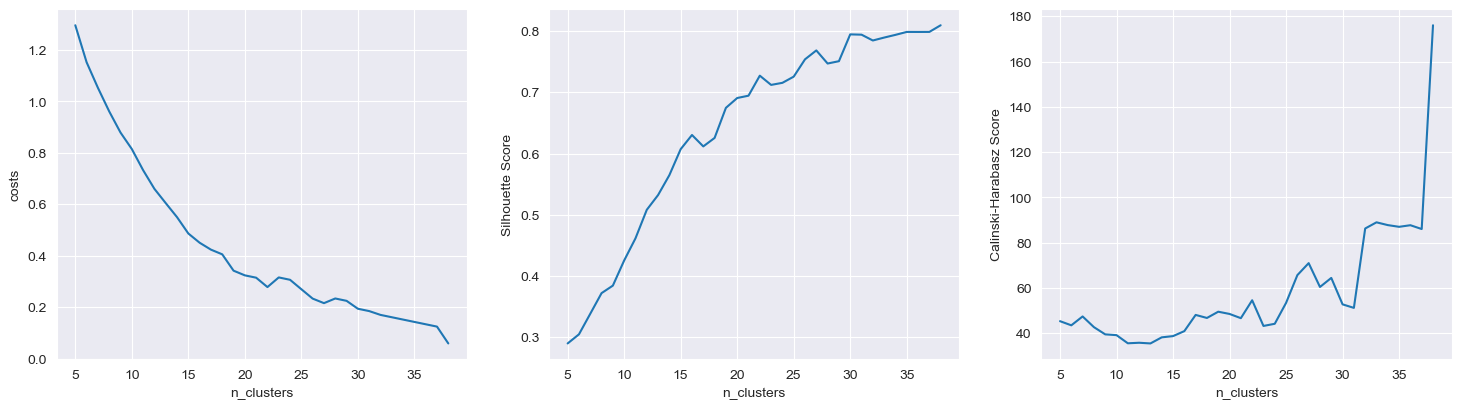

In [7]:
train_results = pd.DataFrame({'n_clusters':n_clusters, 'costs': costs, 'Silhouette Score': s_scores, 'Calinski-Harabasz Score': ch_scores})
multiple_graphs(3, 'n_clusters', train_results)

In [8]:
k_proto = KPrototypes(n_clusters=15, init='Cao', random_state=42, n_jobs=-1)
clusters = k_proto.fit_predict(X, categorical=cats)
s_score = silhouette_score(gower_matrix(X), clusters, metric="precomputed")
ch_score = calinski_harabasz_score(gower_matrix(X), clusters)
print(f"Silhouette Score: {s_score}")
print(f"Calinski-Harabasz Score: {ch_score}")

Silhouette Score: 0.6543911695480347
Calinski-Harabasz Score: 1562.096735853768


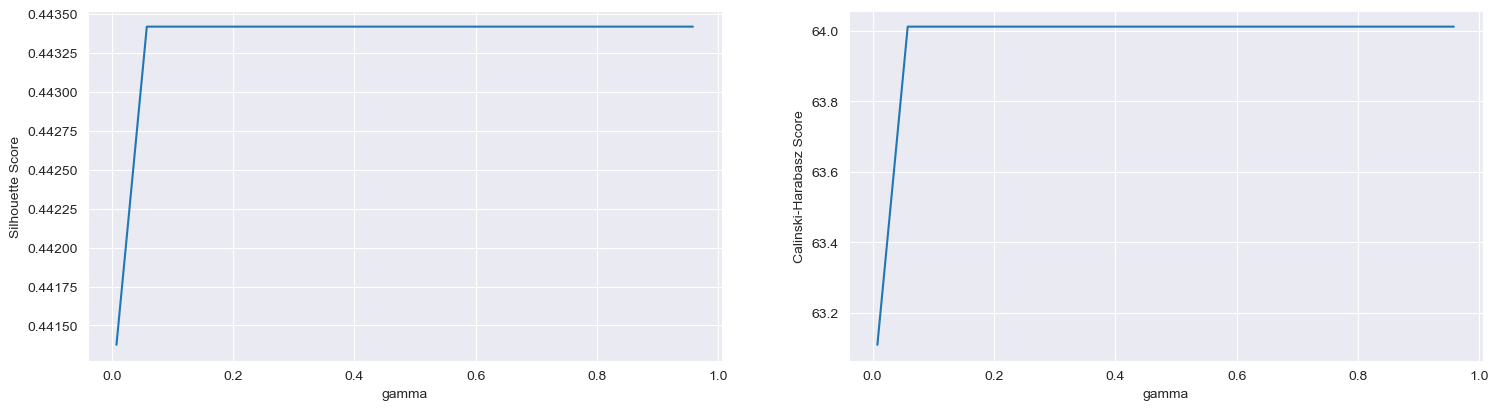

In [9]:
X_cross = X.head(300)
gammas = []
s_scores =  []
ch_scores = []
for gamma in np.arange(0.008,1, 0.05):
    k_proto = KPrototypes(n_clusters=10, init='Cao', random_state=42, n_jobs=-1, gamma=round(gamma, 2))
    clusters = k_proto.fit_predict(X_cross, categorical=cats)
    gammas.append(gamma)
    Xg = gower_matrix(X_cross)
    s_scores.append(silhouette_score(Xg, clusters, metric="precomputed"))
    ch_scores.append(calinski_harabasz_score(Xg, clusters))
test_results = pd.DataFrame({'gamma':gammas, 'Silhouette Score': s_scores, 'Calinski-Harabasz Score': ch_scores})
multiple_graphs(2, 'gamma', test_results)

In [10]:
n=30
k_proto = KPrototypes(n_clusters=n, init='Cao', random_state=42, n_jobs=-1, gamma=.14)
clusters = k_proto.fit_predict(X, categorical=cats)
gm = gower_matrix(X)
s_score = silhouette_score(gm, labels=k_proto.labels_, metric="precomputed")
ch_score = calinski_harabasz_score(gm, k_proto.labels_)
print(f"Silhouette Score: {s_score}")
print(f"Calinski-Harabasz Score: {ch_score}")

Silhouette Score: 0.7758733630180359
Calinski-Harabasz Score: 1189.0057650025833


In [11]:
df['clusters'] = clusters
df.to_csv(f'results_{n}_clusters.csv')

/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


<Axes: >

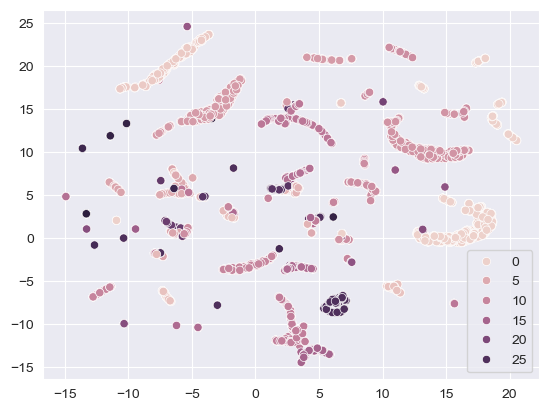

In [12]:
embedding = umap.UMAP(metric='precomputed').fit_transform(gm)
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=clusters)

In [13]:
df.head()

,profile_id,profile_is_child,geo,product_ids,device,delta,positive,negative,genres,hashtags,cls,starts,progress,versions,views_count,clusters
0,80d6ad93-1aa3-40dd-9f85-1bee3f2a8627,0,RU,[c164dd6d-3669-435c-a8f6-b57ca14b0a61],[web],29193298,0,0,"[criminal, drama, action]","[Законы улиц, Кино с характером, Криминальные ...",[Series],[2024-01-22 18:35:28],[1.1449645],[2024-01-22 19:20:38],1,9
1,0cec5794-90fa-467d-9857-43851054dfb3,0,BY,"[608da742-46c3-4a5d-8134-532fd391a456, c0c4fa9...","[tv, tv, tv, tv, tv, tv, tv, tv, tv, tv, tv, t...",590977773,0,0,"[detective, drama, comedy, family, thriller, d...","[Ведется расследование, Мрачная атмосфера, Тай...","[Series, Series, Movie, Series, Series, Series...","[2023-12-22 14:52:55, 2025-03-16 14:13:35, 202...","[0.95737725, 0.014767603, 0.013667554, 0.21475...","[2023-12-22 14:52:55, 2025-03-16 14:17:38, 202...",52,8
2,50820849-495c-4eab-8531-71b294585d3a,0,RU,"[55b61165-1d6d-4216-80f8-95ffda3bd528, e3885f6...","[web, web, web, web, web]",36432828,11,4,"[comedy, family, family, fantasy, adventure, c...","[Вечные ценности, Дела семейные, Душевное, Жиз...","[Series, Series, Series, Series, Series]","[2024-11-19 17:33:47, 2024-10-13 18:33:56, 202...","[0.09395181, 0.8115045, 0.0010829378, 0.000202...","[2024-11-19 18:21:13, 2024-10-13 18:34:17, 202...",5,8
3,0121c8ec-2066-4aa7-a788-db9e6abb65a5,1,RU,[2b085cca-54e2-44ac-b437-ee7607828d1d],[tv],2098083,0,0,"[entertainment, cartoonseries]","[Малышам, Про дружбу, Девочкам]",[Series],[2024-12-03 04:10:59],[0.12762572],[2024-12-03 04:47:59],1,4
4,97de2898-7245-4430-9eaa-1217a7476cc7,0,DE,"[b315e3c5-da4b-4dc7-bc01-62d7761e732d, 608da74...","[mobile, mobile, mobile, mobile, mobile, mobil...",38886428,0,0,"[drama, detective, drama, detective, melodrama...","[Звездный актерский состав, Советское время, О...","[Series, Series, Series, Series, Series, Serie...","[2023-12-17 13:52:34, 2023-11-18 21:47:18, 202...","[0.009468423, 0.012955979, 0.037663378, 0.0026...","[2023-12-17 13:52:41, 2023-11-18 21:51:17, 202...",7,19


In [14]:
exploded_df = df.sort_values('clusters').explode(['product_ids', 'progress'])
exploded_df['progress'] = pd.to_numeric(exploded_df['progress'], errors='coerce')

filtered_positive = exploded_df.where(exploded_df['progress'] > 0.25).dropna()
positive_ids = filtered_positive.groupby(['clusters', 'product_ids'], as_index=False).size()
positive_ids = positive_ids.groupby('clusters').apply(lambda x: x.nlargest(25, 'size'), include_groups=False).reset_index().drop(['level_1'], axis=1).rename(columns={'product_ids': 'positive_ids','size': 'positive_frequency'})
positive_ids = positive_ids.groupby('clusters').aggregate(lambda x: [i for i in x])


filtered_negative = exploded_df.where(exploded_df['progress'] <= 0.25).dropna()
negative_ids = filtered_negative.groupby(['clusters', 'product_ids'], as_index=False).size()
negative_ids = negative_ids.groupby('clusters').apply(lambda x: x.nlargest(25, 'size'), include_groups=False).reset_index().drop(['level_1'], axis=1).rename(columns={'product_ids': 'negative_ids','size': 'negative_frequency'})
negative_ids = negative_ids.groupby('clusters').aggregate(lambda x: [i for i in x])


ids = pd.concat([positive_ids, negative_ids], axis=1).reset_index(['clusters'])
ids.to_csv('positive_negative_ids.csv')
